## This version: 28 procedures

### Load Order_Procedure from BQ

In [1]:
# example: read from BigQuery chart to numpy
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
import numpy as np
import pandas as pd



client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
query = "select * from `som-nero-phi-jonc101.Clinical_Collaborative_Filtering.spec_proc_v2`"; # Example dataset table


# to DataFrame

df_all = (
    client.query(query)
    .result()
    .to_dataframe()
)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
N_proc = 60
df_n = df_all[['PC_enc', 'proc_name']]
temp_df = df_n.groupby(['proc_name']).apply(len).reset_index().rename(columns={'proc_name':'proc_name', 0:'num'}) #, as_index=False  
T = temp_df.sort_values('num',ascending=False).head(N_proc)['proc_name'].to_numpy()
for i in range(N_proc):
    print(T[i])



TSH
T4, FREE
VITAMIN D, 25-HYDROXYVITAMIN
METABOLIC PANEL, COMPREHENSIVE
HEMOGLOBIN A1C
PARATHYROID HORMONE
METABOLIC PANEL, BASIC
CORTISOL, SERUM
ANTI - TPO AB
PHOSPHORUS, SERUM/PLASMA
ALBUMIN WITH CREATININE, URINE (RANDOM)
TSH W/ REFLEX FT4
PROLACTIN
US THYROID
CREATININE, URINE (TIMED)
CALCIUM, URINE (TIMED)
FSH
T3, FREE
ADRENOCORTICOTROPIC HORMONE (ACTH)
CALCIUM, SERUM/PLASMA
LAB UNLISTED 1
LIPID PANEL WITH DIRECT LDL
LUTEINIZING HORMONE
LIPID PANEL WITH CALCULATED LDL
T3, TOTAL
BONE ALKALINE PHOSPHATASE, SERUM
IGA ANTI  TTG
C - PEPTIDE, SERUM
DXA ADULT
TESTOSTERONE, TOTAL, BIO, FREE
HGB A1C W/ EST MEAN GLUCOSE
MAGNESIUM, SERUM/PLASMA
THYROID-STIMULATING IMMUNOGLOBULIN (TSI)
COLLAGEN TYPE I C-TELOPEPTIDE (CTX)
ALBUMIN, SERUM/PLASMA
TSH AND FREE T4
THYROGLOBULIN AND TGAB COMPREHENSIVE
VITAMIN B12
THYROGLOBULIN AB ULTRA-SENSITIVE
CBC WITH DIFFERENTIAL
TESTOSTERONE
DEHYDROEPIANDROSTERONE, SULFATE
ESTRADIOL
CBC W/O DIFF
CREATININE, SERUM/PLASMA
BONE DENSITY ADULT
INSULIN-LIKE GROWTH F

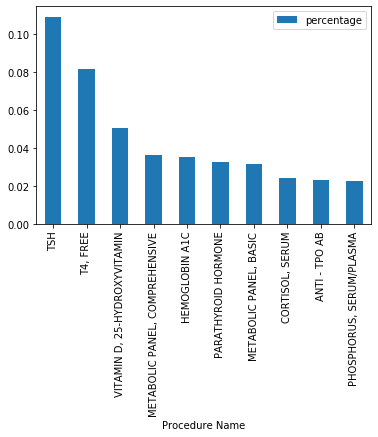

In [4]:
df= df_n
lendf = df.shape[0]
df_plot = df['proc_name'].value_counts().head(10).reset_index().rename(columns={'index':'Procedure Name','proc_name':'percentage' })
df_plot['percentage' ]=df_plot['percentage' ]/lendf
df_plot.plot.bar(x='Procedure Name',y='percentage' )

### Remove unnecessary columns and rows

In [4]:
print(df_all.head())

# only take PC_enc and proc_id
df = df_all[['PC_enc', 'proc_id']]

# remove duplicate rows:
df = df.drop_duplicates()

print(df.head())

     jc_uid        PC_enc     PC_app_datetime     PC_ref_datetime  \
0  JCdf9b24  131190115844 2016-07-21 14:00:00 2016-07-21 14:33:00   
1  JCdf9b24  131190115844 2016-07-21 14:00:00 2016-07-21 14:33:00   
2  JCd062ef  131193047867 2016-08-16 14:15:00 2016-08-17 10:41:00   
3  JCd062ef  131193047867 2016-08-16 14:15:00 2016-08-17 10:41:00   
4  JCe9e8a2  131256960011 2018-09-22 00:00:00 2018-09-22 11:49:00   

         SP_enc     SP_app_datetime order_type  proc_id  \
0  131190408679 2016-08-31 09:00:00        Lab     1944   
1  131190408679 2016-08-31 09:00:00        Lab     2220   
2  131197339532 2016-08-23 09:30:00        Lab   196616   
3  131197339532 2016-08-23 09:30:00        Lab   196616   
4  131257160718 2018-12-11 13:40:00        Lab    70199   

                              proc_name     proc_order_time prov_id  
0                              T4, FREE 2016-08-31 09:28:00    None  
1                                   TSH 2016-08-31 09:28:00    None  
2  OCCULT BLD, GUAIA

### Create the table of unique encounter id

In [5]:
unq_PC_enc = df.groupby(['PC_enc']).apply(len).reset_index().rename(columns={'proc_id':'proc_id', 0:'num_unq_proc'}).sort_values('num_unq_proc',ascending=False)  
print(unq_PC_enc.head())
print('All of the encounters with at least one proc order: ',len(unq_PC_enc))
print('Average order per encounter: ', np.mean(unq_PC_enc.num_unq_proc.to_numpy()))
print('Min order per encounter: ', np.min(unq_PC_enc.num_unq_proc.to_numpy()))
print('Max order per encounter: ', np.max(unq_PC_enc.num_unq_proc.to_numpy()))

            PC_enc  num_unq_proc
4533  131094507503            32
3715  131049295970            30
5228  131182751483            28
4787  131126530538            27
3284  131033859921            27
All of the encounters with at least one proc order:  9613
Average order per encounter:  4.7122646416311245
Min order per encounter:  1
Max order per encounter:  32


### Choose only specific proc names

In [10]:
Top_proc = [ ['TSH'],
                  ['A1C'],
                  ['MICROALB'],
                  ['CHOL','LIPID', 'LDL'],
                  ['CREATININE', 'METABOLIC', 'METAB', 'RENAL FUNCTION', 'ELECTROLYTE', 'BMP8+EGFR','CHEM 10','CHEM23'],
                  ['RETINA'],
                  ['CALCIUM IONIZED','CALCIUM, SERUM/PLASMA','CALCIUM (MANUAL ENTRY)','CHEM 10','CHEM23','COMPREHENSIVE METABOLIC PANEL 14'],
                  ['ALBUMIN'],
                  ['PTH','PARATHYROID HORMONE'],
                  ['NUC PARATHYROID SCAN','NM PARATHYROID','TC99M SESTAMIBI'],
                  ['T4'],
                  ['T3'],
                  ['TSI','THYROID STIMULATING IMMUNOGLOBULIN', 'THYROID STIM IMMUNOGLOBULIN' 'RECEPTOR A','TBII'],
                  ['TPO AB'],
                  ['THYROID FUNCTION SCAN AND UPTAKE', 'THYROID UPTAKE AND SCAN', 'THYROID IMAGE UPTAKE'],
                  ['C-TELOPEPTIDE'],
                  ['TELOPEPTIDE, URINE', 'N-TELOPEPTIDE'],
                  ['VITAMIN D, 25-HYDROXY','VITAMIN D 25-HYDROXY','25 HYDROXY','VITAMIN D, 25-OH','VITAMIN D25-OH','VITAMIN D, 25-OH'],
                  ['25 OH VITAMIN D','VITAMIN D, 1,25', 'VITAMIN D 1,25', '1,25-DIHYDROXYVITAMIN'],
                  ['ALKALINE PHOSPHATASE TOTAL','TOTAL ALK','CHEM23', 'COMPREHENSIVE METABOLIC PANEL', 'METABOLIC PANEL, COMPREHENSIVE'],
                  ['BONE ALKALINE','ALKP. PHOSPHATASE', 'ALKALINE PHOSPHATASE', 'LIVER PANEL'],
                  ['SPEP', 'PROTEIN ELECTROPHORESIS','PROTEIN IMMUNOFIX ELECTROPHORESIS'],
                  ['URINE PROTEIN IMMUNOFIXATION ELECTROPHORESIS'],
                  ['US THYROID'],
                  ['US SOFT TISS HEAD','US HEAD NECK'],
                  ['FNA'],
                  ['THYROGLOBULIN'],
                  ['CALCIUM, 24', 'CALCIUM 24', 'CALCIUM,24', 'CALCIUM, URINE (TIMED)']
                 ]
                  
                  
                  


N_proc = len(Top_proc)
print(N_proc)
                  
                  

28


### Create Feature Matrix of Lab Results

In [11]:
import sys

for i in range(N_proc):
    
    # define the search function
    def my_func(df):
        L = Top_proc[i]
        s = 0
        for j in range(len(L)):
            s = s + len(df[df['proc_name'].str.contains(L[j])])
        return int(s>0)
    
    #def my_func(df):
    #    return int(len(df[df['proc_name'].str.contains(Top_proc_names[i])])>0)
    
    F_df = df_n.groupby(['PC_enc']).apply(my_func).reset_index().rename(columns={'PC_enc':'PC_enc', 0:'F'+str(i)}) 
    unq_PC_enc = pd.merge(unq_PC_enc, F_df, how='left', on='PC_enc')
    
    # report i 
    sys.stdout.write('\r')
    sys.stdout.write(str(i/N_proc*100)+'%')
    sys.stdout.flush()


print(unq_PC_enc.head())


17.857142857142858%

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


96.42857142857143%%         PC_enc  num_unq_proc  F0  F1  F2  F3  F4  F5  F6  F7  ...  F18  F19  \
0  131094507503            32   1   0   0   0   1   0   1   0  ...    1    1   
1  131049295970            30   1   0   0   0   1   0   1   1  ...    0    1   
2  131182751483            28   1   1   0   0   1   0   0   0  ...    0    1   
3  131126530538            27   1   0   0   0   1   0   1   0  ...    0    1   
4  131033859921            27   1   0   0   0   1   0   1   0  ...    0    1   

   F20  F21  F22  F23  F24  F25  F26  F27  
0    1    1    1    0    0    0    1    0  
1    1    1    1    0    0    0    0    0  
2    1    0    0    0    0    0    0    0  
3    1    0    0    0    0    0    0    0  
4    1    1    1    0    0    0    0    0  

[5 rows x 30 columns]


### Save the Results into CSV

In [12]:
print(len(unq_PC_enc))
#print(unq_PC_enc.sort_values('F0',ascending=False))
#print(np.sum(unq_PC_enc['F0'].to_numpy()))
unq_PC_enc.to_csv('SP_proc_v3.csv', index=False)

9613


### Test my_func

In [90]:
def my_func(dfi):
    a = int(len(dfi[dfi['proc_id']==2220])>0)
    return a #pd.DataFrame({'main':dfi, 'func': a })

#print(df.columns)
#print(df.head())
F_df  = df.groupby('PC_enc').apply(my_func).reset_index().rename(columns={'PC_enc':'PC_enc', 0:'F'}) 
print('Check')
df_temp = pd.merge(unq_PC_enc, F_df, how='left', on='PC_enc')
print(np.sum(df_temp['F'].to_numpy()))
print(df_temp.head())

Check
4913
         PC_enc  num_unq_proc  F
0  131094507503            32  1
1  131049295970            30  1
2  131182751483            29  1
3  131235992610            28  1
4  131194373585            27  1
